In [2]:
# install and test tensorflow env on my machine MacM1: https://www.youtube.com/watch?v=5DgWvU0p2bk
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import platform

print(f"Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"Numpy {np.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Platform: macOS-13.1-arm64-arm-64bit
Tensor Flow Version: 2.9.0
Keras Version: 2.9.0

Python 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]
Pandas 1.5.2
Scikit-Learn 1.2.0
Numpy 1.23.2
GPU is available


In [3]:
from pathlib import Path
from PIL import Image
import albumentations as aug
import random
from matplotlib import pyplot as plt
import os

In [4]:
import my_classes as mc

# Loading the data and Creating 8 classes annotation
## Data description
After we downloaded the Cityscapes dataset we discover it's content and give some breaf introduction here.

The folder dataset containes the folowing :

 - leftImg8bit : the images of the dataset, I rename it to images/
 - gtFine/ : contains the images, I rename this folder into masks/
 - test/, train/ and val/ : contains the the three splits of the dataset
 - berlin/, frankfurt/, munich/, ... : contains the images that corresponds to different cities
 - *_gtFine_color.png : contains the labels colors
 - *_gtFine_instanceIds.png : contains the instance ids
 - *_gtFine_labalIds.png : contains the label ids
 - *_gtFine_polygons.json : contains the polygon shapes
 

We are not going to use the polygon shapes, but we will use the instance ids to build the ground truth images.

The dataset contains :
 - 2975 train images
 - 500 validation images
 - 1525 test images

According to the Cityscapes dataset documentation, the images are of size 2048x1024 and are in RGB format.

We will not use the object labels (32 labels), but the 8 label categories : "void", "flat", "construction", "object", "nature", "sky", "human" and "vehicle".

In [95]:
# Let's load the images 
data_path = Path("data")
images_path = Path(data_path, "images")
masks_path = Path(data_path, "masks")

In [96]:
# Train dataset
train_input_img_paths = sorted(
    Path(images_path, "train").glob("**/*_leftImg8bit.png")
)
train_label_ids_img_paths = sorted(
    Path(masks_path, "train").glob("**/*_gtFine_labelIds.png")
)
train_label_color_img_paths = sorted(
    Path(masks_path, "train").glob("**/*_color.png")
)

# Validation dataset
val_input_img_paths = sorted(
    Path(images_path, "val").glob("**/*_leftImg8bit.png")
)
val_label_ids_img_paths = sorted(
    Path(masks_path, "val").glob("**/*_gtFine_labelIds.png")
)
val_label_colors_img_paths = sorted(
    Path(masks_path, "val").glob("**/*_color.png")
)

# Test dataset
test_input_img_paths = sorted(
    Path(images_path, "test").glob("**/*_leftImg8bit.png")
)
test_label_ids_img_paths = sorted(
    Path(masks_path, "test").glob("**/*_gtFine_labelIds.png")
)
test_label_colors_img_paths = sorted(
    Path(masks_path, "test").glob("**/*_color.png")
)

Let us write the files that we will need for our data generation, everything being ordonated:
 - train_input_img_paths
 - train_label_ids_img_paths
 - val_input_img_paths
 - val_label_ids_img_paths
 - test_input_img_paths
 - test_label_ids_img_paths

In [97]:
with open('data/train_images.txt', 'w') as f:
    f.write("\n".join(str(item) for item in train_input_img_paths))
with open('data/train_mask.txt', 'w') as f:
    f.write("\n".join(str(item) for item in train_label_ids_img_paths))
with open('data/val_images.txt', 'w') as f:
    f.write("\n".join(str(item) for item in val_input_img_paths))
with open('data/val_mask.txt', 'w') as f:
    f.write("\n".join(str(item) for item in val_label_ids_img_paths))
with open('data/test_images.txt', 'w') as f:
    f.write("\n".join(str(item) for item in test_input_img_paths))
with open('data/test_mask.txt', 'w') as f:
    f.write("\n".join(str(item) for item in test_label_ids_img_paths))

In [98]:
print('We have {0} train images'.format(len(train_input_img_paths)))
print('We have {0} validation images'.format(len(val_input_img_paths)))
print('We have {0} test images'.format(len(test_input_img_paths)))

We have 2974 train images
We have 500 validation images
We have 1525 test images


Next we take a random image and try to understand each file from the data.

In [117]:
rand_idx = np.random.randint(0, len(val_input_img_paths))
image_id = (
    str(val_input_img_paths[rand_idx])
    .split("/")[-1]
    .replace("_leftImg8bit.png", "")
)
img = np.array(Image.open(val_input_img_paths[rand_idx]))
ids_img = np.array(np.array(Image.open(val_label_ids_img_paths[rand_idx])))
img_size = img.shape
color_img = np.array(np.array(Image.open(val_label_colors_img_paths[rand_idx])))
ids_img_size = ids_img.shape
color_img_size = color_img.shape

print('The size image is: {0}'.format(img_size))
print('The size ids image is: {0}'.format(ids_img_size))
print('The size color image is: {0}'.format(color_img_size))

The size image is: (1024, 2048, 3)
The size ids image is: (1024, 2048)
The size color image is: (1024, 2048, 4)


Note that 
 - each image has the size of (1024, 2048) with dimension 3 that is the RGB.
 - the label_ids images sizes are (1024, 2048) that tells us the label associated to that pixel
 - color image has the size of (1024, 2048) with dimension 4. The first 3 dimensions is the RGB and the fourth layer is the alpha chanel which is added to allow the transparency of the image (it does not change the color of the pixel). Also, we note that this is equal to 255 for all the times, there is why we can delete it.
 
Also we observe there is 1024 * 2048 = 2097152 pixels in the image.

Let us see the color of the first pixel in the image

In [118]:
img[0,0,:]

array([34, 45, 62], dtype=uint8)

Let us see the ids of the first pixel in the labelIds image. 

In [119]:
ids_img[0,0]

3

This correspons to 3, that meens that the first pixel is attributed to the **void** cathegory.

In [120]:
np.unique(ids_img)

array([ 1,  2,  3,  4,  5,  7,  8, 11, 12, 17, 19, 20, 21, 22, 23, 24, 25,
       26, 33], dtype=uint8)

In [121]:
len(np.unique(ids_img))

19

We also see that there are labels from 1 to 33. And for this image we have 17 different labels.

In [122]:
color_img = color_img[:,:,:3]
color_img_size = color_img.shape
print('The size color image is: {0}'.format(color_img_size))

The size color image is: (1024, 2048, 3)


In [123]:
color_img[0,0,:]

array([0, 0, 0], dtype=uint8)

In [124]:
1024*2048

2097152

In [125]:
color_img.reshape(-1,3).shape

(2097152, 3)

## Colors in the image

In [126]:
colours, counts = np.unique(color_img.reshape(-1,3), axis=0, return_counts=1)
for j in range(len(colours)):
    print('{0}/{1}:{2}'.format(j, colours[j], counts[j]))

0/[0 0 0]:276171
1/[  0   0 142]:19697
2/[70 70 70]:240320
3/[ 70 130 180]:95763
4/[102 102 156]:7754
5/[107 142  35]:428094
6/[111  74   0]:1804
7/[119  11  32]:31545
8/[128  64 128]:852620
9/[152 251 152]:4334
10/[153 153 153]:50127
11/[220  20  60]:4529
12/[220 220   0]:3501
13/[244  35 232]:63408
14/[250 170  30]:3663
15/[255   0   0]:13822


## Image anotation

In [127]:
def count_label_anotation(ann_img):
    colours, counts = np.unique(ann_img, return_counts=1)
    for j in range(len(colours)):
        print('{0}/{1}:{2}'.format(j, colours[j], counts[j]))

In [128]:
count_label_anotation(ids_img)

0/1:121096
1/2:74098
2/3:31634
3/4:49343
4/5:1804
5/7:852620
6/8:63408
7/11:240320
8/12:7754
9/17:50127
10/19:3663
11/20:3501
12/21:428094
13/22:4334
14/23:95763
15/24:4529
16/25:13822
17/26:19697
18/33:31545


## Transform 8 classes annotation

In [129]:
cats = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
 }

cats_replace = {0: [0, 1, 2, 3, 4, 5, 6],
 1: [7, 8, 9, 10],
 2: [11, 12, 13, 14, 15, 16],
 3: [17, 18, 19, 20],
 4: [21, 22],
 5: [23],
 6: [24, 25],
 7: [26, 27, 28, 29, 30, 31, 32, 33, -1]
 }

cats_id = {
 'void': 0,
 'flat': 1,
 'construction': 2,
 'object': 3,
 'nature': 4,
 'sky': 5,
 'human':6,
 'vehicle': 7
}

cats_colors = {
 'void': (0,0,0),
 'flat': (50,50,50),
 'construction': (150,150,150),
 'object': (255,0,0),
 'nature': (0,255,0),
 'sky': (0,0,255),
 'human':(200,200,0),
 'vehicle': (150,0,200)
}

In [130]:
mask_labelids = pd.DataFrame(ids_img)
for new_value, old_value in cats_replace.items():
    mask_labelids = mask_labelids.replace(old_value, new_value);
mask_labelids = mask_labelids.to_numpy()

In [131]:
count_label_anotation(mask_labelids)

0/0:277975
1/1:916028
2/2:248074
3/3:57291
4/4:432428
5/5:95763
6/6:18351
7/7:51242


Observe that there is no humans annotated in the picture. Let us show the original picture with the annotation picture.

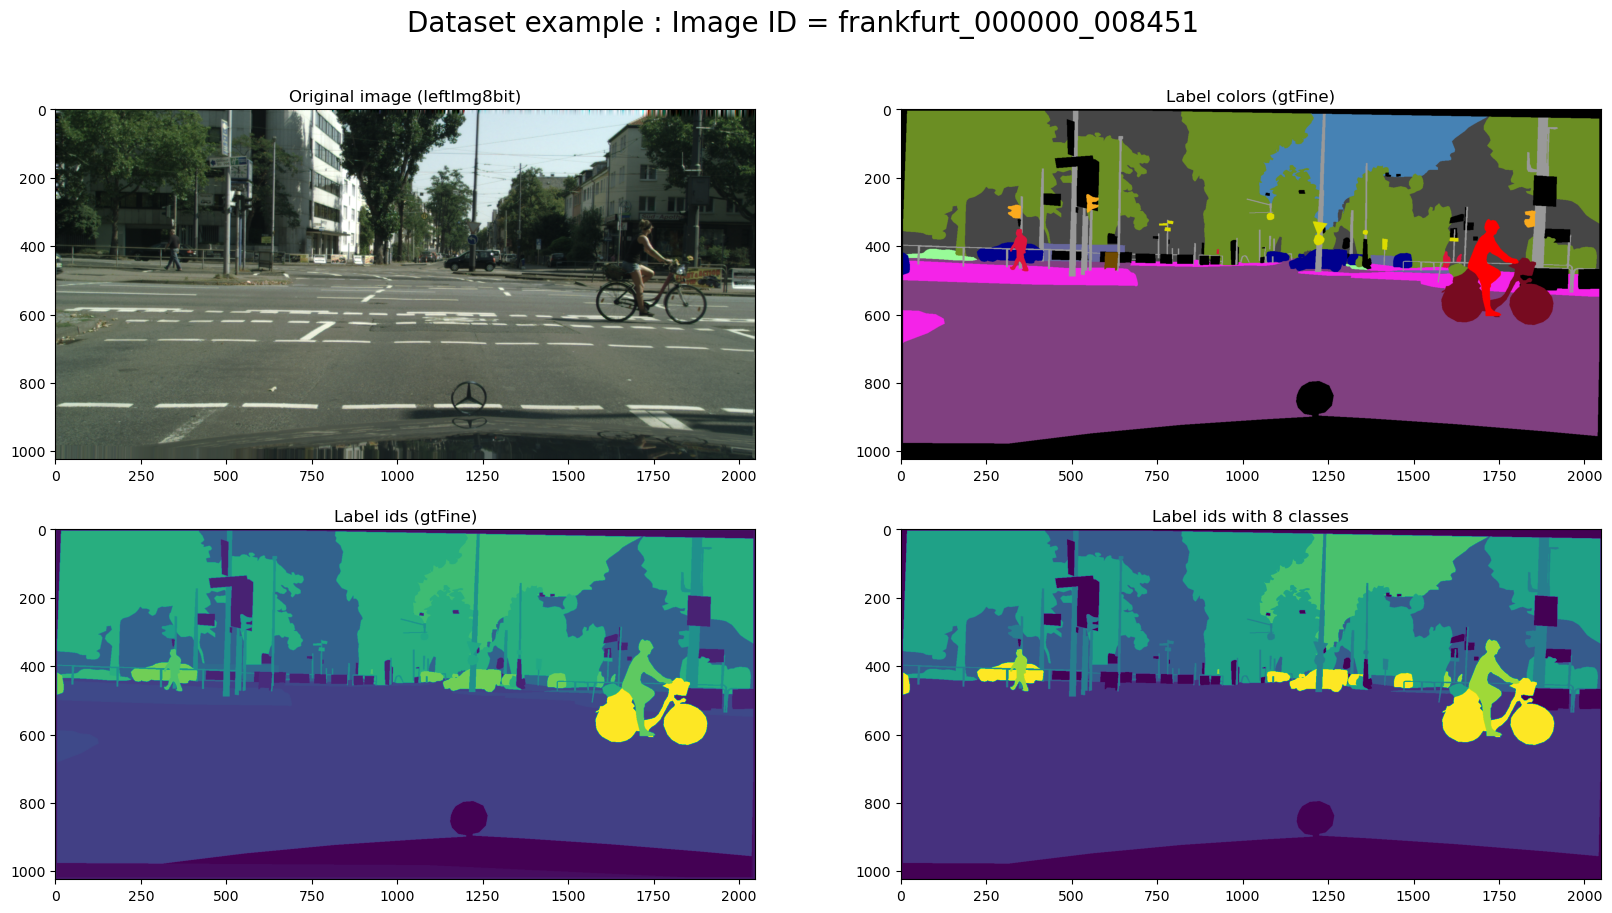

In [132]:
# plot images
fig, ax = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(20, 10),
)
fig.suptitle(f"Dataset example : Image ID = {image_id}", fontsize=20)

ax[0, 0].title.set_text("Original image (leftImg8bit)")
ax[0, 0].imshow(img)

ax[0, 1].title.set_text("Label colors (gtFine)")
ax[0, 1].imshow(color_img)

ax[1, 0].title.set_text("Label ids (gtFine)")
ax[1, 0].imshow(np.array(ids_img))

ax[1, 1].title.set_text("Label ids with 8 classes")
ax[1, 1].imshow(np.array(mask_labelids))

plt.show()

In [133]:
ids_img

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]], dtype=uint8)

# Resizing Image and the Mask

In [134]:
import cv2
X = np.array(cv2.resize(cv2.cvtColor(cv2.imread(str(val_input_img_paths[rand_idx])), cv2.COLOR_BGR2RGB), (256, 128)))
y = np.array(cv2.resize(cv2.imread(str(val_label_ids_img_paths[rand_idx]),0), (256, 128)))

In [135]:
np.unique(y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33],
      dtype=uint8)

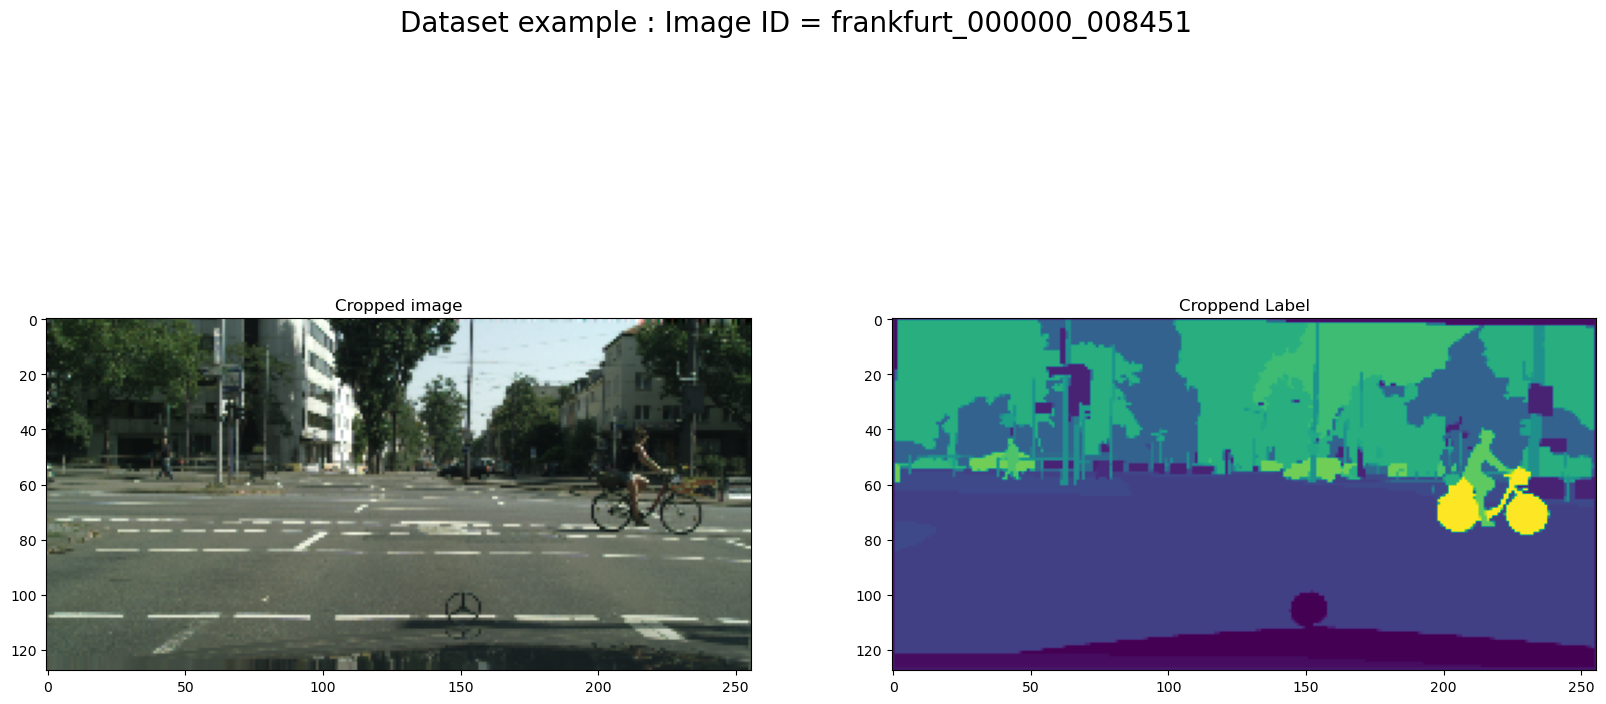

In [136]:
# plot images
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(20, 10),
)
fig.suptitle(f"Dataset example : Image ID = {image_id}", fontsize=20)

ax[0].title.set_text("Cropped image")
ax[0].imshow(X)

ax[1].title.set_text("Croppend Label")
ax[1].imshow(y)

# Augmentation images

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.
If you not familiar with such trick read some of these articles:

[The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)

Data Augmentation | How to use Deep Learning when you have Limited Data
Data Augmentation Experimentation
Since our dataset is very small we will apply a large number of different augmentations:

- horizontal flip
- affine transforms
- perspective transforms
- brightness/contrast/colors manipulations
- image bluring and sharpening
- gaussian noise
- random crops

All this transforms can be easily applied with Albumentations - fast augmentation library. For detailed explanation of image transformations you can look at kaggle salt segmentation exmaple provided by Albumentations authors.

Let us now see an exemple of how we can augment the images. We will take the original image and the label ids with 8 annotated classes and we will use the albumentations class to augment the images.

In [145]:
transform = aug.Compose(
    [
        aug.OneOf(  # Color augmentations
            [
                aug.RandomBrightnessContrast(),
                aug.RandomGamma(),
                aug.RandomToneCurve(),
            ]
        ),
        aug.OneOf(  # Camera augmentations
            [
                aug.MotionBlur(),
                aug.GaussNoise(),
            ]
        ),
        aug.OneOf(  # Geometric augmentations
            [
                aug.HorizontalFlip(),
                aug.RandomCrop(
                    width=int(img_size[1] / random.uniform(1.0, 2.0)),
                    height=int(img_size[0] / random.uniform(1.0, 2.0)),
                ),
                aug.SafeRotate(
                    limit=15,
                ),
            ]
        ),
    ]
)

augmented = transform(
    image=img,
    mask=mask_labelids,
)

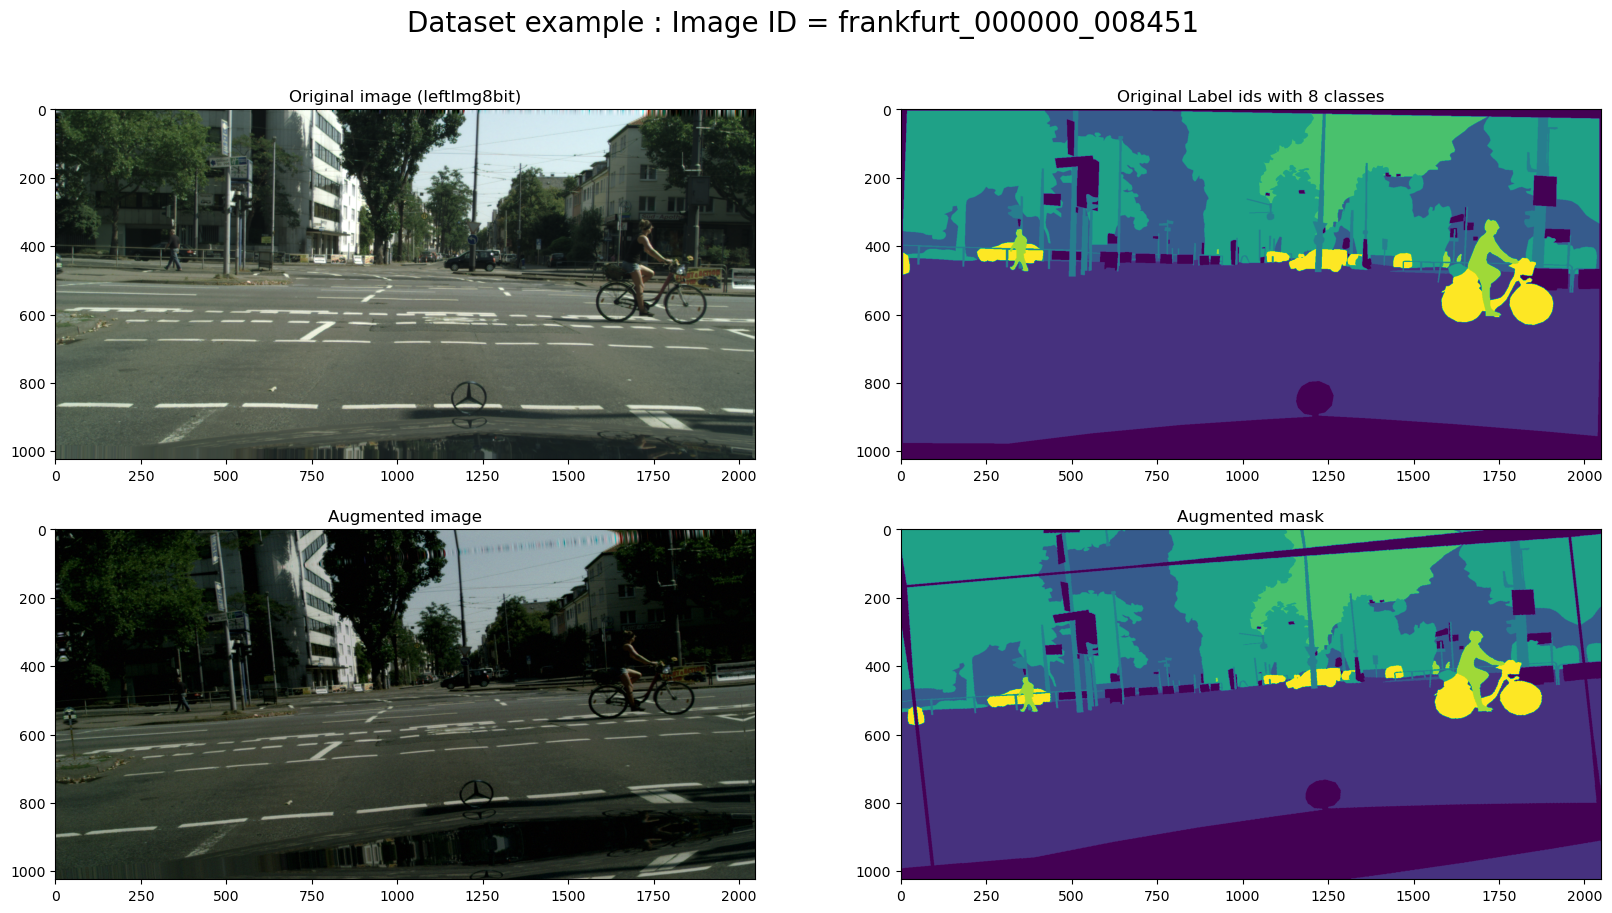

In [146]:
# plot images
fig, ax = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(20, 10),
)
fig.suptitle(f"Dataset example : Image ID = {image_id}", fontsize=20)

ax[0,0].title.set_text("Original image (leftImg8bit)")
ax[0,0].imshow(img)

ax[0,1].title.set_text("Original Label ids with 8 classes")
ax[0,1].imshow(np.array(mask_labelids))

ax[1,0].title.set_text("Augmented image")
ax[1,0].imshow(np.array(augmented["image"]))

ax[1,1].title.set_text("Augmented mask")
ax[1,1].imshow(np.array(augmented["mask"]))

plt.show()

Observe an color, camera and geometric augmentation.

In [5]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        aug.HorizontalFlip(p=0.5),

        aug.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        aug.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        aug.RandomCrop(height=320, width=320, always_apply=True),

        aug.IAAAdditiveGaussianNoise(p=0.2),
        aug.IAAPerspective(p=0.5),

        aug.OneOf(
            [
                aug.CLAHE(p=1),
                aug.RandomBrightness(p=1),
                aug.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        aug.OneOf(
            [
                aug.IAASharpen(p=1),
                aug.Blur(blur_limit=3, p=1),
                aug.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        aug.OneOf(
            [
                aug.RandomContrast(p=1),
                aug.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        aug.Lambda(mask=round_clip_0_1)
    ]
    return aug.Compose(train_transform)


def get_training_augmentation2():
    train_transform = [

        aug.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        aug.RandomCrop(height=320, width=320, always_apply=True),

        aug.Lambda(mask=round_clip_0_1)
    ]
    return aug.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        aug.PadIfNeeded(384, 480)
    ]
    return aug.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        aug.Lambda(image=preprocessing_fn),
    ]
    return aug.Compose(_transform)

# Dataset and DataLoader

Know we create the dataset and the dataloader in my_classes.py

In [6]:
# Lets look at augmented data we have
x_train_dir = 'train_images.txt'
y_train_dir = 'train_mask.txt'
image_id = 10
dataset = mc.Dataset(x_train_dir, y_train_dir)
dataset_aug = mc.Dataset(x_train_dir, y_train_dir, augmentation=get_training_augmentation())
image, mask = dataset[image_id] # get some sample
image_aug, mask_aug = dataset_aug[image_id] # get some sample

/opt/homebrew/Caskroom/miniforge/base/envs/oc8/lib/python3.9/site-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/oc8/lib/python3.9/site-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/oc8/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/oc8/lib/python3.9/site-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpe

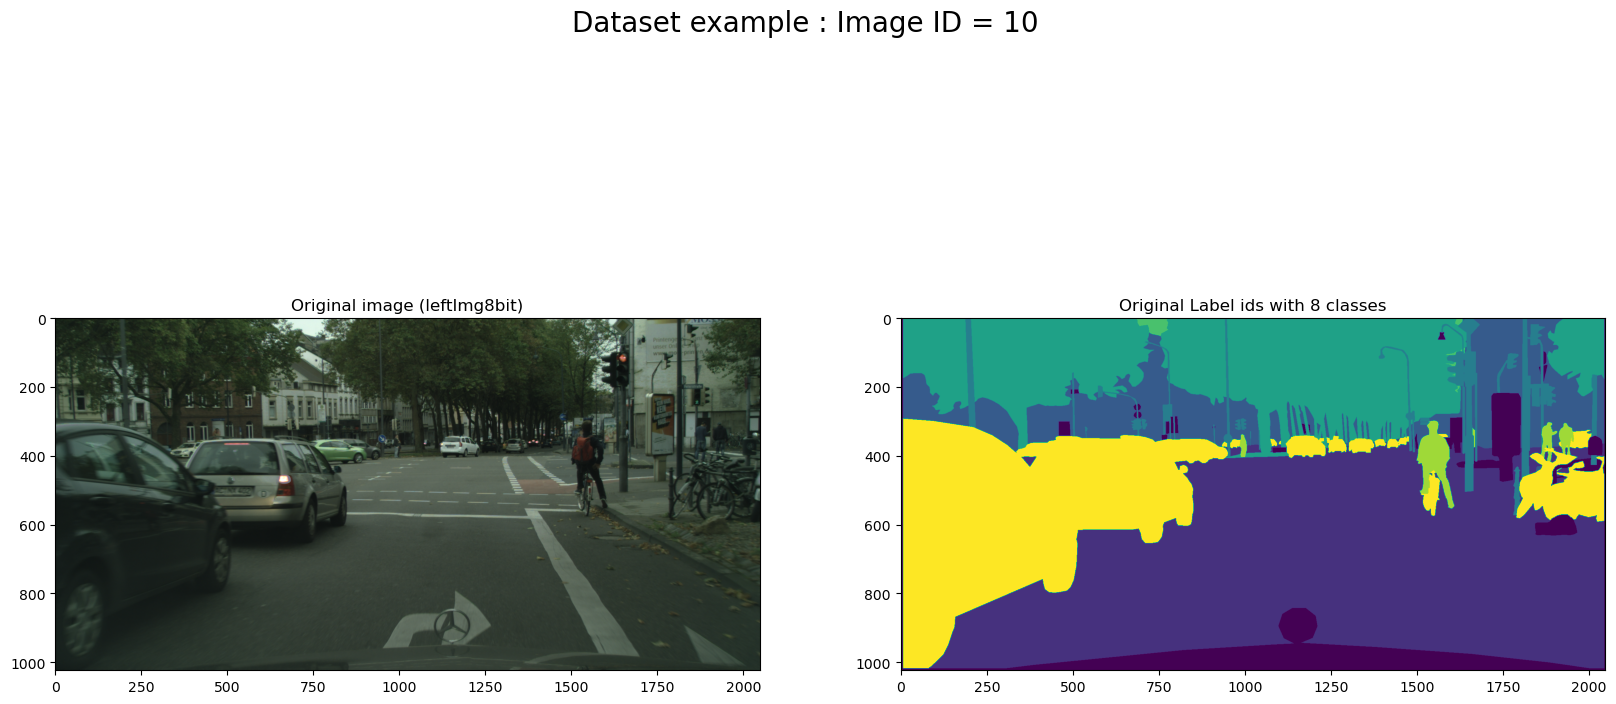

In [171]:
# plot images
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(20, 10),
)
fig.suptitle(f"Dataset example : Image ID = {image_id}", fontsize=20)

ax[0].title.set_text("Original image (leftImg8bit)")
ax[0].imshow(image)

ax[1].title.set_text("Original Label ids with 8 classes")
ax[1].imshow(np.argmax(mask, 2))


plt.show()

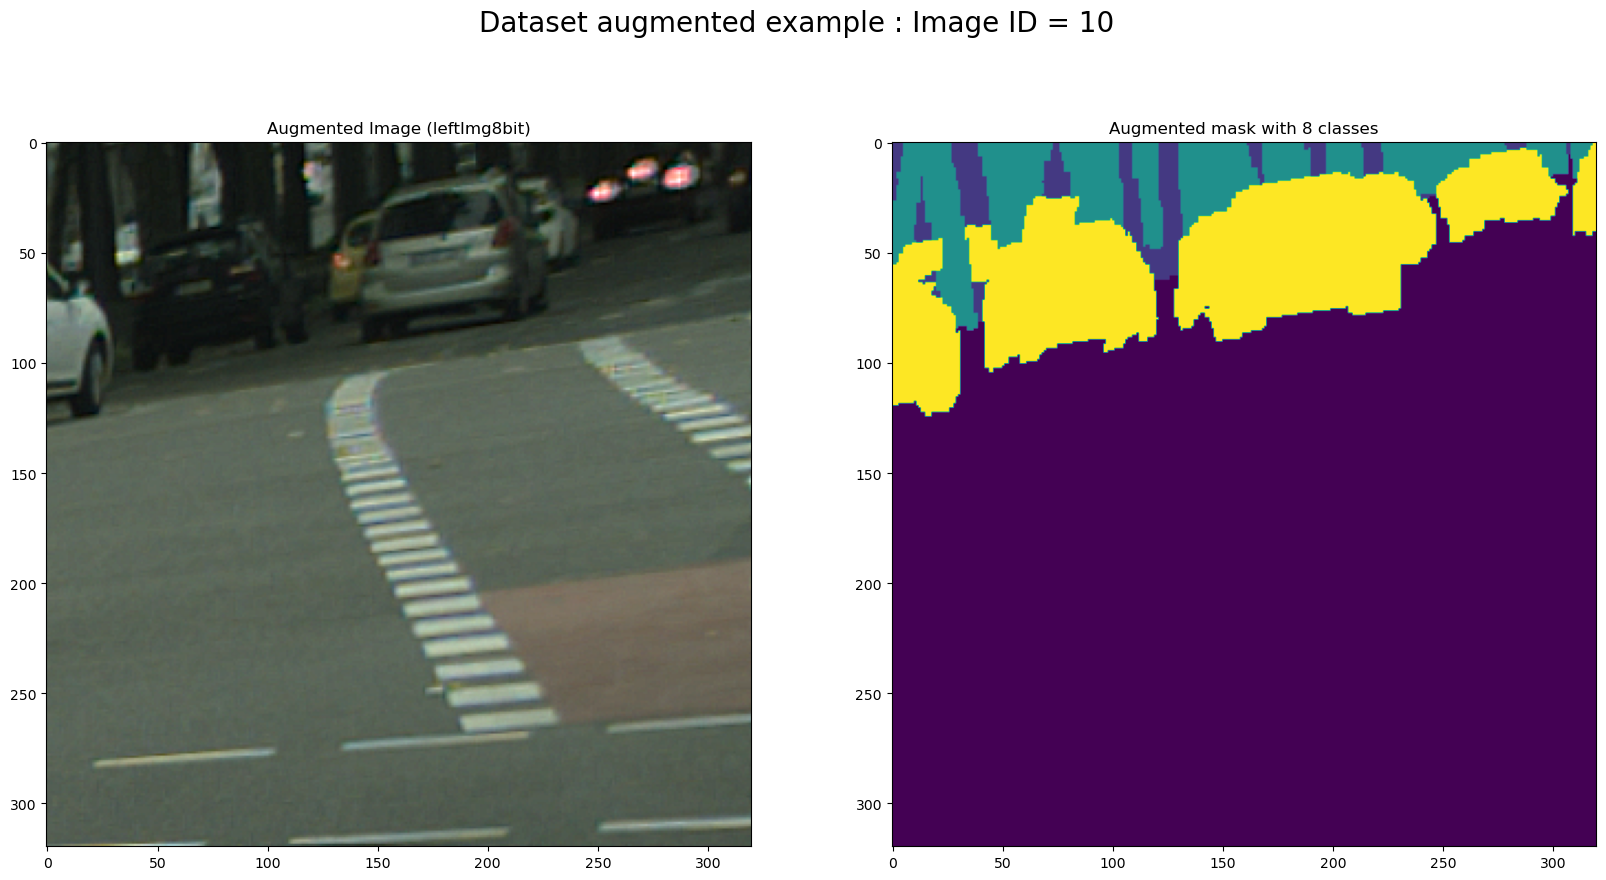

In [172]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(20, 10),
)
fig.suptitle(f"Dataset augmented example : Image ID = {image_id}", fontsize=20)

ax[0].title.set_text("Augmented Image (leftImg8bit)")
ax[0].imshow(image_aug)

ax[1].title.set_text("Augmented mask with 8 classes")
ax[1].imshow(np.argmax(mask_aug, 2))

plt.show()

# Modeling

## UNet Model (without augmentation)

In [4]:
import segmentation_models as sm
print(f"segmentation_models Version: {sm.__version__}")

Segmentation Models: using `keras` framework.
segmentation_models Version: 1.0.1


In [5]:
BATCH_SIZE = 8
LR = 0.0001
EPOCHS = 10

#preprocess_input = sm.get_preprocessing(BACKBONE)

In [22]:
# define network parameters
n_classes = 8
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(classes=n_classes, activation=activation)

In [23]:
# define optomizer
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1/8]*8))  
#focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss #+ (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [24]:
x_train_dir = 'train_images.txt'
y_train_dir = 'train_mask.txt'

x_valid_dir = 'val_images.txt'
y_valid_dir = 'val_mask.txt'

# Dataset for train images
train_dataset = mc.Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation2(),
    #preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = mc.Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = mc.Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = mc.Dataloder(valid_dataset, batch_size=1, shuffle=False)

In [25]:
train_dataloader[0][0].shape

(8, 320, 320, 3)

In [26]:
# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model_without_aug.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
]

In [27]:
# train model
history_without_aug = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

/var/folders/1y/1jw5mb9979bdkjf9r9nkdrq00000gn/T/ipykernel_35025/3885859552.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_without_aug = model.fit_generator(


Epoch 1/10


2023-01-06 15:24:52.558344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


371/371 [==============================] - ETA: 0s - loss: 0.9747 - iou_score: 0.1561 - f1-score: 0.1990

2023-01-06 15:38:25.290583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


371/371 [==============================] - 1041s 3s/step - loss: 0.9747 - iou_score: 0.1561 - f1-score: 0.1990 - val_loss: 0.9621 - val_iou_score: 0.2627 - val_f1-score: 0.3219 - lr: 1.0000e-04
Epoch 2/10
371/371 [==============================] - 1039s 3s/step - loss: 0.9641 - iou_score: 0.2494 - f1-score: 0.3138 - val_loss: 0.9547 - val_iou_score: 0.3198 - val_f1-score: 0.3926 - lr: 1.0000e-04
Epoch 3/10
371/371 [==============================] - 1043s 3s/step - loss: 0.9586 - iou_score: 0.2880 - f1-score: 0.3562 - val_loss: 0.9498 - val_iou_score: 0.3429 - val_f1-score: 0.4140 - lr: 1.0000e-04
Epoch 4/10
371/371 [==============================] - 1049s 3s/step - loss: 0.9551 - iou_score: 0.3031 - f1-score: 0.3722 - val_loss: 0.9419 - val_iou_score: 0.3948 - val_f1-score: 0.4835 - lr: 1.0000e-04
Epoch 5/10
371/371 [==============================] - 1054s 3s/step - loss: 0.9535 - iou_score: 0.3123 - f1-score: 0.3919 - val_loss: 0.9409 - val_iou_score: 0.3870 - val_f1-score: 0.4819 - l

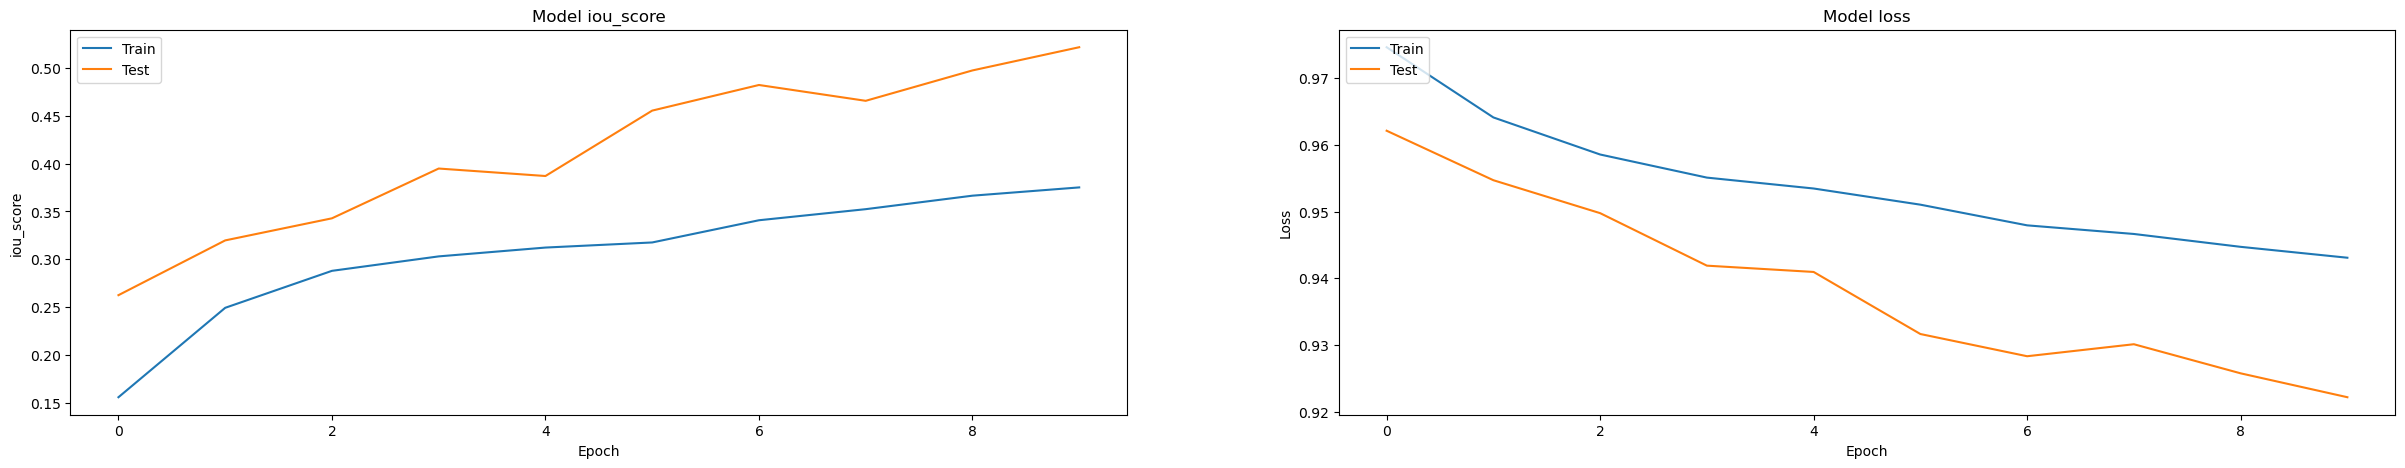

In [28]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history_without_aug.history['iou_score'])
plt.plot(history_without_aug.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history_without_aug.history['loss'])
plt.plot(history_without_aug.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [29]:
import pickle
pickle.dump(history_without_aug, open("history_without_aug.pkl", "wb"))

#to load history
#history = pickle.load(open("history_without_aug.pkl","rb"))

INFO:tensorflow:Assets written to: ram://9f6c42ab-c620-486e-ab86-9df07e23c55b/assets


INFO:tensorflow:Assets written to: ram://9f6c42ab-c620-486e-ab86-9df07e23c55b/assets


In [30]:
# load best weights
model.load_weights('best_model_without_aug.h5') 

In [31]:
x_test_dir = 'val_images.txt'
y_test_dir = 'val_mask.txt'

test_dataset_origin = mc.Dataset(
    x_test_dir, 
    y_test_dir, 
)

x_test_dir = 'val_images.txt'
y_test_dir = 'val_mask.txt'

test_dataset = mc.Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = mc.Dataloder(test_dataset, batch_size=1, shuffle=False)

In [32]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/var/folders/1y/1jw5mb9979bdkjf9r9nkdrq00000gn/T/ipykernel_35025/3518042878.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_dataloader)


Loss: 0.92215
mean iou_score: 0.52147
mean f1-score: 0.62958


In [38]:
image_id = 20
image_id_end = 26
for en, i in enumerate(range(image_id, image_id_end)):
    print(en, i)

0 20
1 21
2 22
3 23
4 24
5 25


1/1 [==============================] - 0s 448ms/step


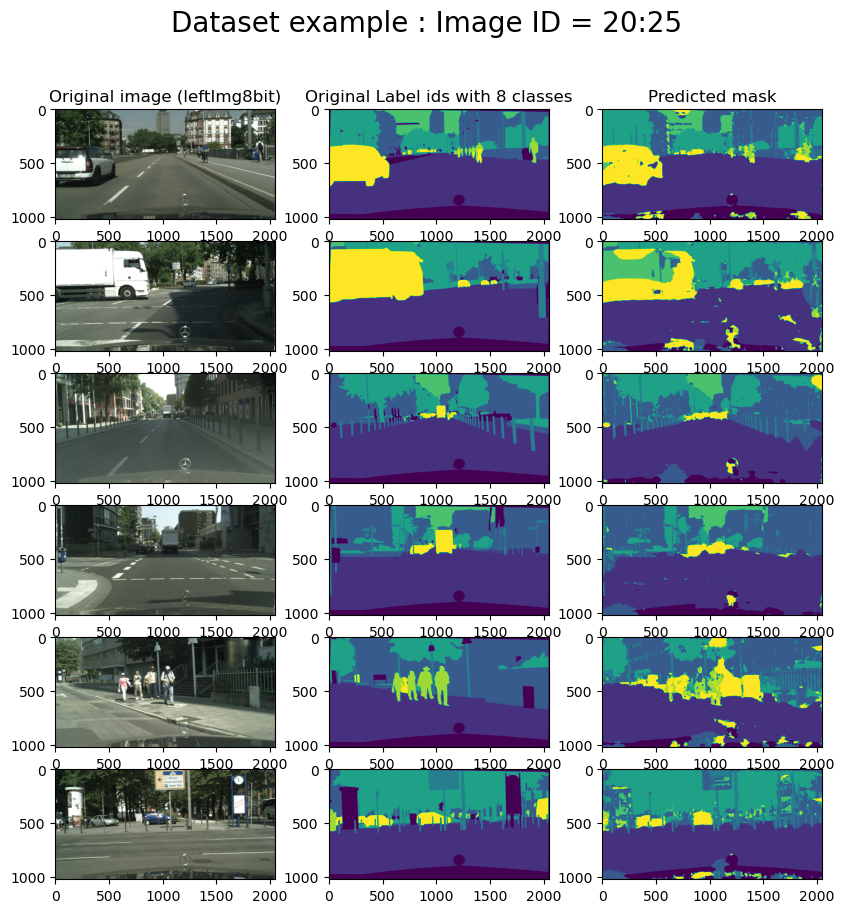

In [42]:
image_id = 20
image_id_end = 26

# plot images
fig, ax = plt.subplots(
    nrows=image_id_end - image_id,
    ncols=3,
    figsize=(10, 10),
)
fig.suptitle("Dataset example : Image ID = {0}:{1}".format(image_id,image_id_end-1), fontsize=20)


for row, i in enumerate(range(image_id, image_id_end)):
    image, mask = test_dataset[i]
    image_origin, mask_origin = test_dataset_origin[i]

    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    if row==0:
        ax[row, 0].title.set_text("Original image (leftImg8bit)")
        ax[row, 1].title.set_text("Original Label ids with 8 classes")
        ax[row, 2].title.set_text("Predicted mask")
        
    ax[row, 0].imshow(image_origin.squeeze())
    ax[row, 1].imshow(np.argmax(mask_origin, 2))
    ax[row, 2].imshow(np.argmax(pr_mask.squeeze(), 2))
    
plt.show()

## UNet Model (with augmentation)

In [10]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [3]:
print(f"segmentation_models Version: {sm.__version__}")

segmentation_models Version: 1.0.1


In [5]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [47]:
# define network parameters
n_classes = 8
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [22]:
# define optomizer
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1/8]*8))  
#focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss #+ (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [23]:
x_train_dir = 'train_images.txt'
y_train_dir = 'train_mask.txt'

x_valid_dir = 'val_images.txt'
y_valid_dir = 'val_mask.txt'

# Dataset for train images
train_dataset = mc.Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = mc.Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = mc.Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = mc.Dataloder(valid_dataset, batch_size=1, shuffle=False)

/opt/homebrew/Caskroom/miniforge/base/envs/oc8/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/oc8/lib/python3.9/site-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/oc8/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [24]:
# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

In [25]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
]

In [26]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

/var/folders/1y/1jw5mb9979bdkjf9r9nkdrq00000gn/T/ipykernel_74683/719100779.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10


2022-12-29 18:59:40.746497: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-29 18:59:44.418008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


371/371 [==============================] - ETA: 0s - loss: 0.9709 - iou_score: 0.2133 - f1-score: 0.2712

2022-12-29 19:15:53.742658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


371/371 [==============================] - 1166s 3s/step - loss: 0.9709 - iou_score: 0.2133 - f1-score: 0.2712 - val_loss: 0.9419 - val_iou_score: 0.4531 - val_f1-score: 0.5392 - lr: 1.0000e-04
Epoch 2/10
371/371 [==============================] - 1149s 3s/step - loss: 0.9556 - iou_score: 0.3183 - f1-score: 0.4024 - val_loss: 0.9295 - val_iou_score: 0.5158 - val_f1-score: 0.6110 - lr: 1.0000e-04
Epoch 3/10
371/371 [==============================] - 1145s 3s/step - loss: 0.9503 - iou_score: 0.3331 - f1-score: 0.4256 - val_loss: 0.9248 - val_iou_score: 0.5247 - val_f1-score: 0.6348 - lr: 1.0000e-04
Epoch 4/10
371/371 [==============================] - 1144s 3s/step - loss: 0.9469 - iou_score: 0.3417 - f1-score: 0.4422 - val_loss: 0.9172 - val_iou_score: 0.5676 - val_f1-score: 0.6777 - lr: 1.0000e-04
Epoch 5/10
371/371 [==============================] - 1151s 3s/step - loss: 0.9434 - iou_score: 0.3652 - f1-score: 0.4664 - val_loss: 0.9128 - val_iou_score: 0.6052 - val_f1-score: 0.7116 - l

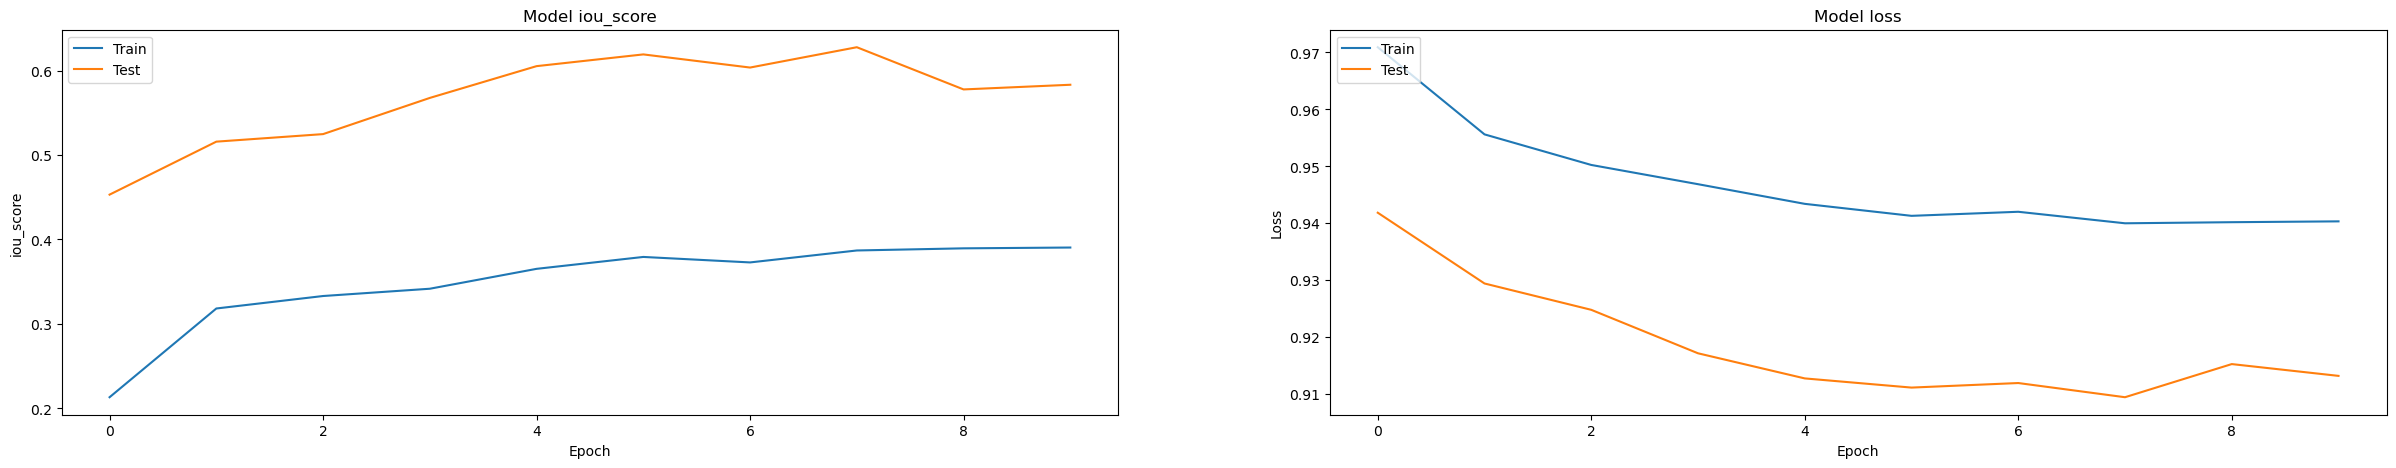

In [27]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [39]:
import pickle
pickle.dump(history, open("history.pkl", "wb"))

#to load history
#history = pickle.load(open("history.pkl","rb"))

INFO:tensorflow:Assets written to: ram://7301cb4d-408c-4ae0-adf7-58935920dc2b/assets


INFO:tensorflow:Assets written to: ram://7301cb4d-408c-4ae0-adf7-58935920dc2b/assets


In [48]:
# load best weights
model.load_weights('best_model.h5') 

In [15]:
x_test_dir = 'val_images.txt'
y_test_dir = 'val_mask.txt'

test_dataset_origin = mc.Dataset(
    x_test_dir, 
    y_test_dir, 
)

In [50]:
x_test_dir = 'val_images.txt'
y_test_dir = 'val_mask.txt'

test_dataset = mc.Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = mc.Dataloder(test_dataset, batch_size=1, shuffle=False)

In [31]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/var/folders/1y/1jw5mb9979bdkjf9r9nkdrq00000gn/T/ipykernel_74683/3518042878.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_dataloader)


Loss: 0.90948
mean iou_score: 0.62761
mean f1-score: 0.73222


2023-01-06 22:57:17.770654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 433ms/step


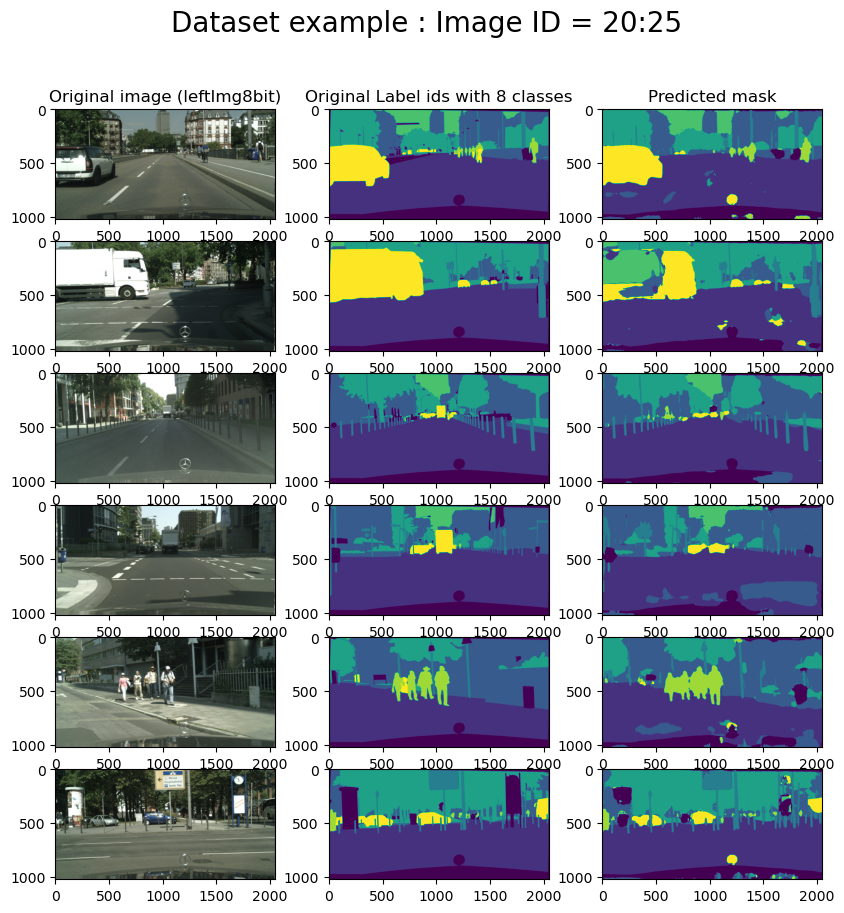

In [51]:
image_id = 20
image_id_end = 26

# plot images
fig, ax = plt.subplots(
    nrows=image_id_end - image_id,
    ncols=3,
    figsize=(10, 10),
)
fig.suptitle("Dataset example : Image ID = {0}:{1}".format(image_id,image_id_end-1), fontsize=20)


for row, i in enumerate(range(image_id, image_id_end)):
    image, mask = test_dataset[i]
    image_origin, mask_origin = test_dataset_origin[i]

    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    if row==0:
        ax[row, 0].title.set_text("Original image (leftImg8bit)")
        ax[row, 1].title.set_text("Original Label ids with 8 classes")
        ax[row, 2].title.set_text("Predicted mask")
        
    ax[row, 0].imshow(image_origin.squeeze())
    ax[row, 1].imshow(np.argmax(mask_origin, 2))
    ax[row, 2].imshow(np.argmax(pr_mask.squeeze(), 2))
    
plt.show()